# TensorFlow 2.x による多変量LSTM

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd drive/MyDrive/tf_multi_LSTM/

# データの読み込みと確認

In [ ]:
# ライブラリのインポート
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import time

In [ ]:
# データ読み込み
df = pd.read_csv('/content/tokyo_weather.csv')
df['date'] = pd.to_datetime(df['date'])
# df.set_index('date', inplace=True)  # index を date にする場合
df

,date,ave_temperature,ave_humidity,total_daylight_hours,total_precipitation,ave_wind_speed,ave_cloud_cover
0,2010-12-21,9.0,43,49.3,43.5,3.0,2.6
1,2010-12-28,6.5,43,48.7,0.0,2.4,4.1
2,2011-01-04,5.6,35,59.2,0.0,3.6,2.1
3,2011-01-11,4.0,36,50.8,0.0,2.7,3.8
4,2011-01-18,5.6,40,56.6,3.5,2.4,3.8
...,...,...,...,...,...,...,...
517,2020-11-17,17.0,65,46.9,0.0,3.2,5.1
518,2020-11-24,11.2,70,26.0,5.0,2.3,7.7
519,2020-12-01,8.6,77,30.5,11.5,2.0,5.6
520,2020-12-08,10.1,68,25.2,0.0,2.1,7.1


## データの可視化

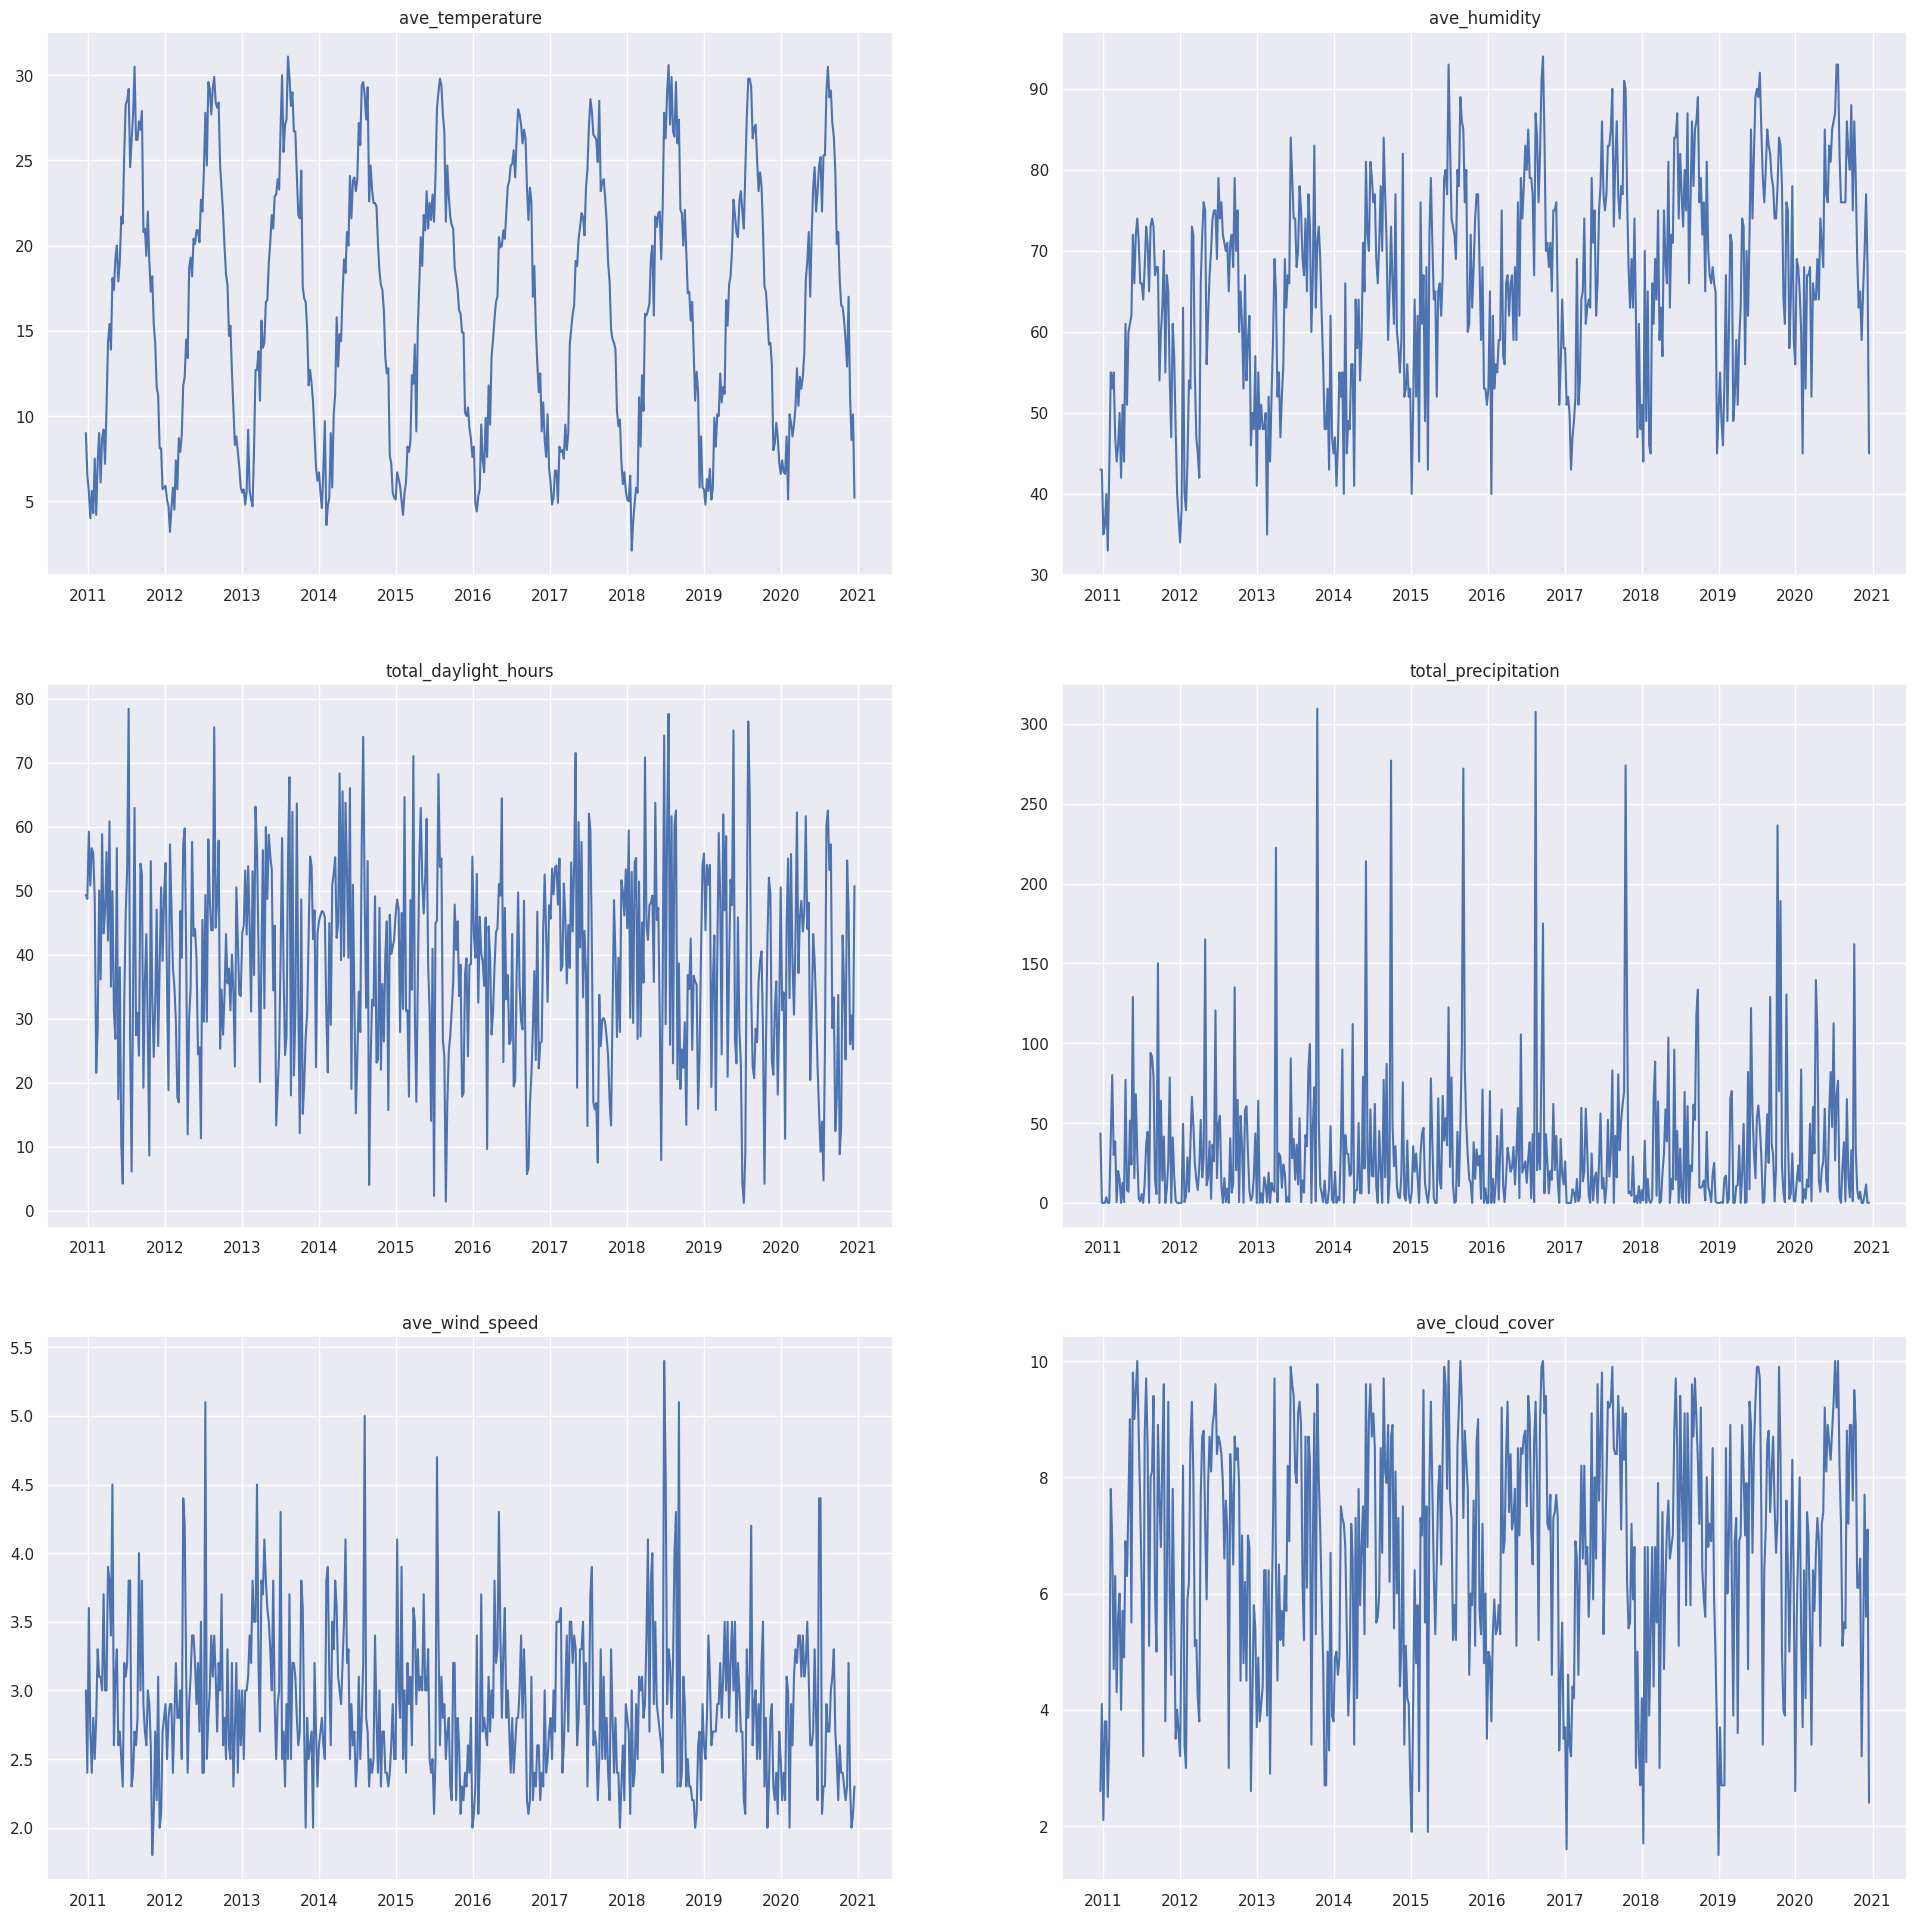

In [ ]:
columns = list(df.columns)
del columns[0]

sns.set()
fig, axs = plt.subplots(3, 2, figsize=(24, 24))

for i in range(3):
    for j in range(2):
        axs[i, j].plot(df['date'], df[columns[i*2+j]])
        axs[i, j].set_title(columns[i*2+j])

plt.show()

## 相関係数の確認

In [ ]:
df_corr = df.corr()
df_corr

<ipython-input-18-0c96883f2151>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df.corr()


,ave_temperature,ave_humidity,total_daylight_hours,total_precipitation,ave_wind_speed,ave_cloud_cover
ave_temperature,1.000000,0.684215,-0.072796,0.177788,0.171854,0.529895
ave_humidity,0.684215,1.000000,-0.575097,0.428378,-0.171433,0.771485
total_daylight_hours,-0.072796,-0.575097,1.000000,-0.431813,0.348910,-0.745879
total_precipitation,0.177788,0.428378,-0.431813,1.000000,0.054998,0.415123
ave_wind_speed,0.171854,-0.171433,0.348910,0.054998,1.000000,-0.070544
ave_cloud_cover,0.529895,0.771485,-0.745879,0.415123,-0.070544,1.000000


## データの前処理

In [ ]:
len(df)

522

In [ ]:
# ルックバック数
look_back = 25
# データ数
sample_size = len(df) - look_back
# 予測に用いる期間
past_size = int(sample_size*0.8)
future_size = sample_size - past_size +1

In [ ]:
# データセットを作る関数
def make_dataset(raw_data, look_back=25):
    _X = []
    _y = []

    for i in range(len(raw_data) - look_back):
        _X.append(raw_data[i : i + look_back])
        _y.append(raw_data[i + look_back])
    _X = np.array(_X).reshape(len(_X), look_back, 1)
    _y = np.array(_y).reshape(len(_y), 1)

    return _X, _y

In [ ]:
columns

['ave_temperature',
 'ave_humidity',
 'total_daylight_hours',
 'total_precipitation',
 'ave_wind_speed',
 'ave_cloud_cover']

In [ ]:
df["ave_temperature"][:]

0       9.0
1       6.5
2       5.6
3       4.0
4       5.6
       ... 
517    17.0
518    11.2
519     8.6
520    10.1
521     5.2
Name: ave_temperature, Length: 522, dtype: float64

In [ ]:
from sklearn import preprocessing

# 最小0、最大1に正規化
Xs = []
for i in range(len(columns)):
    Xs.append(preprocessing.minmax_scale(df[columns[i]]))
Xs = np.array(Xs)

X_tmpr, y_tmpr = make_dataset(Xs[0], look_back=look_back)
X_humid, y_humid = make_dataset(Xs[1], look_back=look_back)
X_dlh, y_dlh = make_dataset(Xs[2], look_back=look_back)
X_prec, y_prec = make_dataset(Xs[3], look_back=look_back)
X_ws, y_ws = make_dataset(Xs[4], look_back=look_back)
X_cloud, y_cloud = make_dataset(Xs[5], look_back=look_back)

# 多変量LSTM用に各データを結合
X_con = np.concatenate([X_tmpr, X_humid, X_dlh, X_prec, X_ws, X_cloud], axis=2)

In [ ]:
X = X_con
y = y_cloud

In [ ]:
X.shape

(497, 25, 6)

訓練データ X は (サンプル数, look_back数, 変数の数) の形式になっている。


In [ ]:
y.shape

(497, 1)

教師データ y_train は (サンプル数, 変数の数) の形式になっている。

In [ ]:
# データを過去分（訓練に用いる分）と未来分（未来の予測に用いる分）に分割
X_past = X[:past_size]
X_future = X[past_size-1:]
y_past = y[:past_size]
y_future = y[past_size-1:]

In [ ]:
X_train = X_past
y_train = y_past

# 多変量LSTMモデルによる学習

## モデルの作成

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, BatchNormalization, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

# LSTMモデルを作成する関数
def create_LSTM_model():
    input = Input(shape=(np.array(X_train).shape[1], np.array(X_train).shape[2]))
    x = LSTM(64, return_sequences=True)(input)
    x = BatchNormalization()(x)
    x = LSTM(64)(x)
    output = Dense(1, activation='relu')(x)
    model = Model(input, output)
    return model

# Bidirectional-LSTMモデルを作成する関数
def create_BiLSTM_model():
    input = Input(shape=(np.array(X_train).shape[1], np.array(X_train).shape[2]))
    x = Bidirectional(LSTM(64, return_sequences=True))(input)
    x = BatchNormalization()(x)
    x = Bidirectional(LSTM(64))(x)
    output = Dense(1, activation='relu')(x)
    model = Model(input, output)
    return model

In [ ]:
model = create_LSTM_model()
model.summary()
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 6)]           0         
                                                                 
 lstm (LSTM)                 (None, 25, 64)            18176     
                                                                 
 batch_normalization (Batch  (None, 25, 64)            256       
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 51521 (201.25 KB)
Trainable params: 51393 (200.75 KB)
Non-trainable params: 128 (512.00 Byte)
___________________

In [ ]:
# 学習
t1 = time.time()
history = model.fit(X_train, y_train, epochs = 100, batch_size = 64, verbose = 0)
t2 = time.time()

tt = t2 - t1
t_h = tt//3600
t_m = (tt - t_h*3600)//60
t_s = (tt - t_h*3600 - t_m*60)//1
print('Training Time : '+str(t_h)+' h, '+str(t_m)+' m, '+str(t_s)+' s')

Training Time : 0.0 h, 0.0 m, 30.0 s


## 予測結果の確認

In [ ]:
predictions = model.predict(X_past)
future_predictions = model.predict(X_future)

4/4 [==============================] - 0s 11ms/step


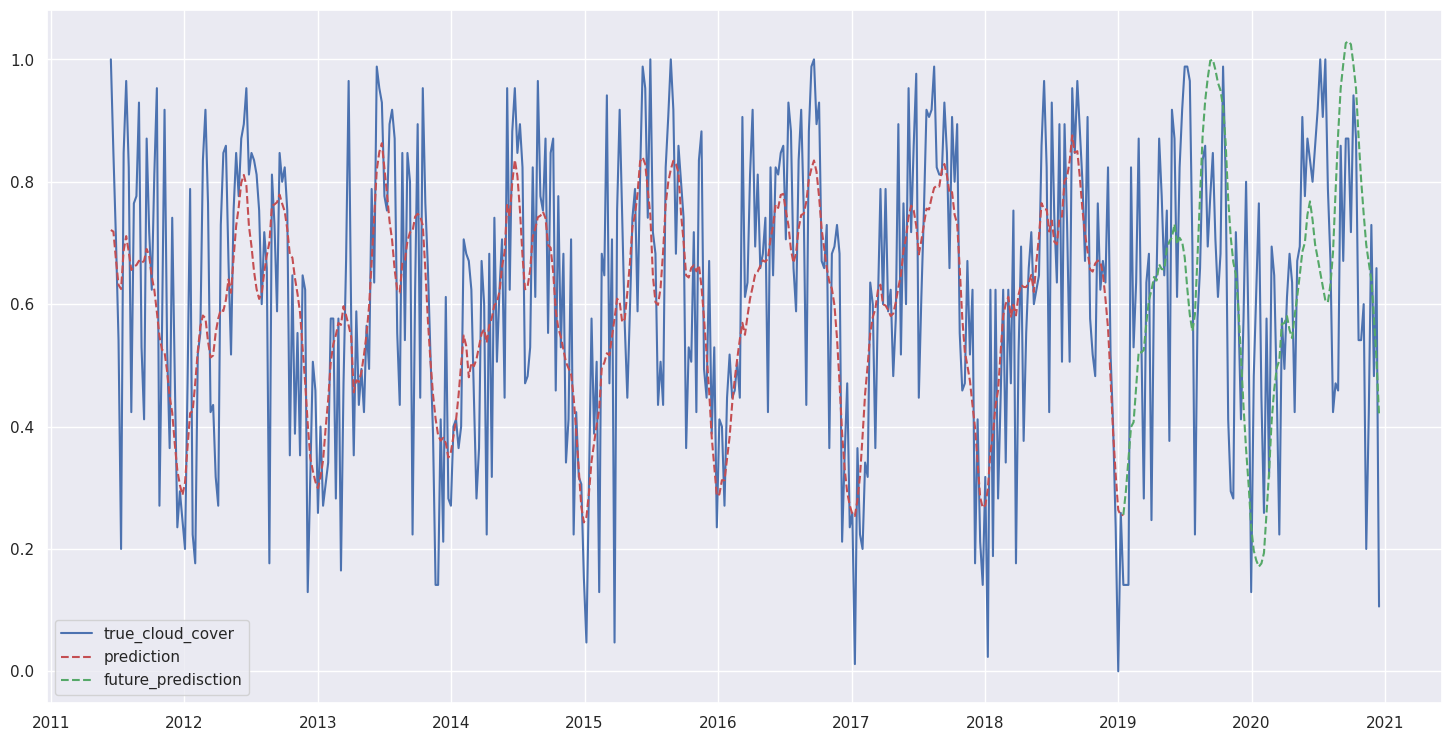

In [ ]:
plt.figure(figsize=(18, 9))
plt.plot(df['date'][look_back:], y, color="b", label="true_cloud_cover")
plt.plot(df['date'][look_back:look_back + past_size], predictions, color="r", linestyle="dashed", label="prediction")
plt.plot(df['date'][-future_size:], future_predictions, color="g", linestyle="dashed", label="future_predisction")
plt.legend()
plt.show()